# Sistem Pemberi Rekomendasi Produk E-Commerce Menggunakan PCA dan K-Means Clustering

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.cm as cm
pd.options.mode.chained_assignment = None  # default='warn'

## Preprocessing

### Load dataset sport

In [2]:
dfp = pd.read_csv('data/olist_sport_rating_dataset.csv')
dfp.shape

(15944, 3)

In [3]:
df = pd.read_csv('data/olist_sport_user_dataset.csv')

In [4]:
df.head()

,customer_unique_id,payment_type,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
0,00053a61a98854899e70ed204dd4bafe,credit_card,3.0,419.18,-25.4313,-49.2792,1.0
1,0005ef4cd20d2893f0d9fbd94d3c0d97,credit_card,4.0,129.76,-2.5453,-44.2350,1.0
2,00115fc7123b5310cf6d3a3aa932699e,credit_card,1.0,76.11,-15.8232,-47.9871,1.0
3,0019e8c501c85848ac0966d45226fa1d,credit_card,2.0,197.27,-15.6087,-56.0863,1.0
4,003c2067070f5b3d923235b1ea1cc17b,boleto,1.0,147.38,-6.5833,-40.1389,1.0


In [5]:
df.describe(include='all')

,customer_unique_id,payment_type,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,7422,7422,7422.000000,7422.000000,7422.000000,7422.000000,7422.000000
unique,7414,4,NaN,NaN,NaN,NaN,NaN
top,d55417a83a73d1702b43988e63f0731a,credit_card,NaN,NaN,NaN,NaN,NaN
freq,2,5668,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.477953,148.886874,-21.282984,-46.327820,1.021692
std,NaN,NaN,2.388320,187.418710,5.524935,4.037406,0.501380
min,NaN,NaN,1.000000,0.050000,-33.689900,-69.261400,1.000000
25%,NaN,NaN,1.000000,65.000000,-23.602700,-48.404400,1.000000
50%,NaN,NaN,1.000000,108.880000,-22.943400,-46.654200,1.000000
75%,NaN,NaN,3.000000,167.185000,-20.188100,-43.920650,1.000000


### Missing data treatment

In [6]:
df.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,7422.000000,7422.000000,7422.000000,7422.000000,7422.000000
mean,2.477953,148.886874,-21.282984,-46.327820,1.021692
std,2.388320,187.418710,5.524935,4.037406,0.501380
min,1.000000,0.050000,-33.689900,-69.261400,1.000000
25%,1.000000,65.000000,-23.602700,-48.404400,1.000000
50%,1.000000,108.880000,-22.943400,-46.654200,1.000000
75%,3.000000,167.185000,-20.188100,-43.920650,1.000000
max,24.000000,4163.510000,3.362100,-34.827400,28.000000


In [7]:
# isi null value pada kolom total_payment_sequential dengan nilai median
df['total_payment_sequential'].fillna(df['total_payment_sequential'].median(), inplace=True)

# isi null value pada kolom total_payment_sequential dengan nilai rata-rata
df['total_payment_installments'].fillna(df['total_payment_installments'].mean(), inplace=True)

# isi null value pada kolom total_payment_value dengan nilai median
df['total_payment_value'].fillna(df['total_payment_value'].median(), inplace=True)

# isi null value pada kolom payment_type dengan nilai median
df['payment_type'].fillna(df['payment_type'].mode().iloc[0], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_unique_id          7422 non-null   object 
 1   payment_type                7422 non-null   object 
 2   total_payment_installments  7422 non-null   float64
 3   total_payment_value         7422 non-null   float64
 4   geolocation_lat             7422 non-null   float64
 5   geolocation_lng             7422 non-null   float64
 6   total_payment_sequential    7422 non-null   float64
dtypes: float64(5), object(2)
memory usage: 406.0+ KB


### Outlier treatment

E:\Program Files\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


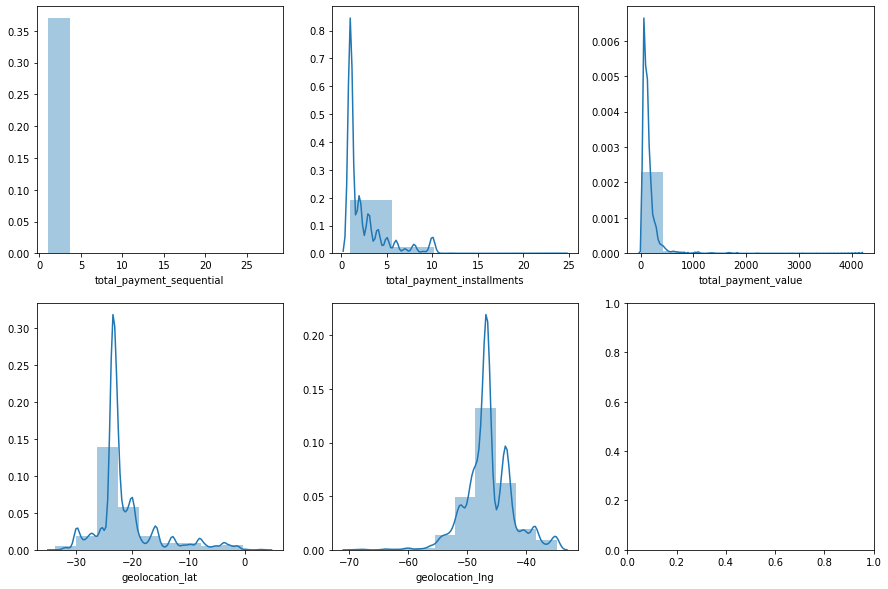

In [9]:
f, ax = plt.subplots(2, 3, figsize=(15,10))
vis1 = sns.distplot(df["total_payment_sequential"], bins=10, ax=ax[0][0])
vis2 = sns.distplot(df["total_payment_installments"],bins=5, ax= ax[0][1])
vis3 = sns.distplot(df["total_payment_value"],bins=10, ax=ax[0][2])
vis4 = sns.distplot(df["geolocation_lat"],bins=10, ax=ax[1][0])
vis5 = sns.distplot(df["geolocation_lng"],bins=10, ax=ax[1][1])

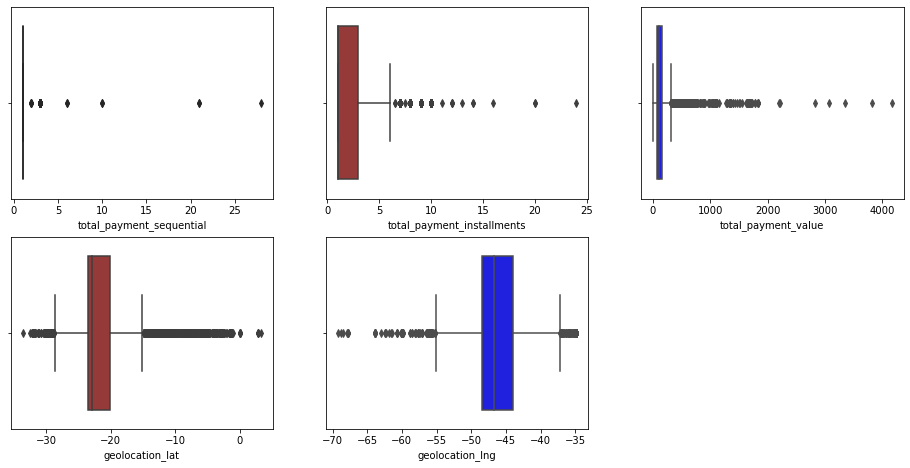

In [10]:
plt.figure(figsize= (16,12))
plt.subplot(3,3,1)
sns.boxplot(x= df['total_payment_sequential'], color='purple')
plt.subplot(3,3,2)
sns.boxplot(x= df['total_payment_installments'], color='brown')
plt.subplot(3,3,3)
sns.boxplot(x= df['total_payment_value'], color='blue')
plt.subplot(3,3,4)
sns.boxplot(x= df['geolocation_lat'], color='brown')
plt.subplot(3,3,5)
sns.boxplot(x= df['geolocation_lng'], color='blue')
plt.show()

In [11]:
df.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,7422.000000,7422.000000,7422.000000,7422.000000,7422.000000
mean,2.477953,148.886874,-21.282984,-46.327820,1.021692
std,2.388320,187.418710,5.524935,4.037406,0.501380
min,1.000000,0.050000,-33.689900,-69.261400,1.000000
25%,1.000000,65.000000,-23.602700,-48.404400,1.000000
50%,1.000000,108.880000,-22.943400,-46.654200,1.000000
75%,3.000000,167.185000,-20.188100,-43.920650,1.000000
max,24.000000,4163.510000,3.362100,-34.827400,28.000000


#### Eliminasi outlier dengan Interquartil Range (IQR)

In [12]:
df.shape

(7422, 7)

In [13]:
# menghitung jumlah row yg dianggap outlier
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
print(IQR)

mask = (df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))
dfout = df.copy()
dfout[mask] = np.nan

total_payment_installments      2.00000
total_payment_value           102.18500
geolocation_lat                 3.41460
geolocation_lng                 4.48375
total_payment_sequential        0.00000
dtype: float64


In [14]:
dfout.isna().sum()

customer_unique_id               0
payment_type                     0
total_payment_installments     596
total_payment_value            467
geolocation_lat               1173
geolocation_lng                308
total_payment_sequential        42
dtype: int64

In [15]:
cleandf = df[~((df < (q1 - 1.5 * IQR)) |(df > (q3 + 1.5 * IQR))).any(axis=1)]
# cleandf.shape

In [16]:
cleandf.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,5476.000000,5476.000000,5476.000000,5476.000000,5476.0
mean,1.807408,109.390414,-22.541442,-46.565584,1.0
std,1.280788,65.830227,2.422928,2.735688,0.0
min,1.000000,0.050000,-28.717400,-54.963200,1.0
25%,1.000000,58.280000,-23.597800,-47.890200,1.0
50%,1.000000,93.020000,-23.048300,-46.659250,1.0
75%,2.000000,144.025000,-21.672950,-44.249675,1.0
max,6.000000,320.230000,-15.152600,-39.041600,1.0


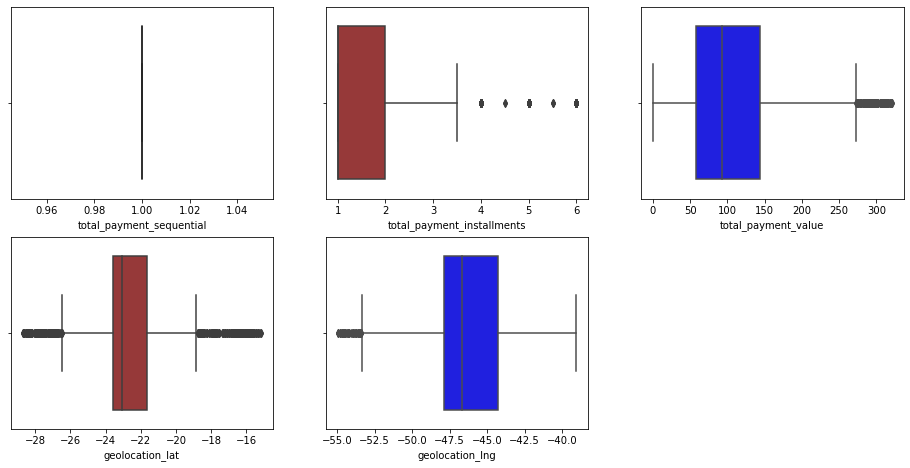

In [17]:
plt.figure(figsize= (16,12))
plt.subplot(3,3,1)
sns.boxplot(x= cleandf['total_payment_sequential'], color='purple')
plt.subplot(3,3,2)
sns.boxplot(x= cleandf['total_payment_installments'], color='brown')
plt.subplot(3,3,3)
sns.boxplot(x= cleandf['total_payment_value'], color='blue')
plt.subplot(3,3,4)
sns.boxplot(x= cleandf['geolocation_lat'], color='brown')
plt.subplot(3,3,5)
sns.boxplot(x= cleandf['geolocation_lng'], color='blue')
plt.show()

### Encoding data
Mengubah categorical data menjadi numerical data

In [18]:
# encode kolom verify dengan nilai True = 1 dan False = 0
df_enc = pd.get_dummies(cleandf, columns=["payment_type"])
# df_enc.head()

In [19]:
df_enc.describe(include='all')

,customer_unique_id,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
count,5476,5476.000000,5476.000000,5476.000000,5476.000000,5476.0,5476.000000,5476.000000,5476.000000,5476.000000
unique,5470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,d55417a83a73d1702b43988e63f0731a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.807408,109.390414,-22.541442,-46.565584,1.0,0.225164,0.745982,0.016253,0.012600
std,NaN,1.280788,65.830227,2.422928,2.735688,0.0,0.417729,0.435347,0.126458,0.111552
min,NaN,1.000000,0.050000,-28.717400,-54.963200,1.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.000000,58.280000,-23.597800,-47.890200,1.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,1.000000,93.020000,-23.048300,-46.659250,1.0,0.000000,1.000000,0.000000,0.000000
75%,NaN,2.000000,144.025000,-21.672950,-44.249675,1.0,0.000000,1.000000,0.000000,0.000000


### Agregasi data

In [20]:
# menyederhanakan df_sample_tmp
df_sample = pd.DataFrame()
df_sample['total_payment_installments'] = df_enc.groupby(['customer_unique_id'])['total_payment_installments'].mean()
df_sample['total_payment_value'] = df_enc.groupby(['customer_unique_id'])['total_payment_value'].mean()
df_sample['geolocation_lat'] = df_enc.groupby(['customer_unique_id'])['geolocation_lat'].mean()
df_sample['geolocation_lng'] = df_enc.groupby(['customer_unique_id'])['geolocation_lng'].mean()
df_sample['total_payment_sequential'] = df_enc.groupby(['customer_unique_id'])['total_payment_sequential'].mean()
df_sample['payment_type_boleto'] = df_enc.groupby(['customer_unique_id'])['payment_type_boleto'].sum()
df_sample['payment_type_credit_card'] = df_enc.groupby(['customer_unique_id'])['payment_type_credit_card'].sum()
df_sample['payment_type_debit_card'] = df_enc.groupby(['customer_unique_id'])['payment_type_debit_card'].sum()
df_sample['payment_type_voucher'] = df_enc.groupby(['customer_unique_id'])['payment_type_voucher'].sum()
df_sample.reset_index(drop=False, inplace=True)
df_sample.shape

(5470, 10)

In [21]:
# menentukan X dan y dataset
X = df_sample.copy()
X.drop(['customer_unique_id'], inplace=True, axis=1)

# y untuk statified splitting data
y = df_sample.loc[:, ["customer_unique_id"]]


In [22]:
X.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,1.0,76.11,-15.8232,-47.9871,1.0,0,1,0,0
1,1.0,103.47,-22.2848,-42.5317,1.0,1,0,0,0
2,1.0,158.74,-23.6295,-46.5241,1.0,1,0,0,0
3,1.0,94.35,-23.5364,-46.7960,1.0,1,0,0,0
4,1.0,123.39,-19.8629,-43.8607,1.0,1,0,0,0


### K-Fold Cross Validation

In [23]:

kf = KFold(n_splits=5, random_state=3, shuffle=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [25]:
print(X_train.shape)
print(X_test.shape)

(4376, 9)
(1094, 9)


In [26]:
# buat kopian df untuk metode pembanding
# km-cf
X_train2 = X_train.copy()
X_test2 = X_test.copy()
y_train2 = y_train.copy()
y_test2 = y_test.copy()

# hc-cf
X_train3 = X_train.copy()
X_test3 = X_test.copy()
y_train3 = y_train.copy()
y_test3 = y_test.copy()

# cf
X_train4 = X_train.copy()
X_test4 = X_test.copy()
y_train4 = y_train.copy()
y_test4 = y_test.copy()


#### Standardize data

In [27]:
X_train.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
count,4376.000000,4376.000000,4376.000000,4376.000000,4376.0,4376.000000,4376.000000,4376.000000,4376.000000
mean,1.805385,109.314465,-22.543019,-46.562386,1.0,0.223720,0.749543,0.015311,0.012797
std,1.269390,65.457421,2.430718,2.731679,0.0,0.416784,0.433326,0.122800,0.112411
min,1.000000,0.050000,-28.717400,-54.963200,1.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,58.710000,-23.599600,-47.887500,1.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,93.875000,-23.081650,-46.659200,1.0,0.000000,1.000000,0.000000,0.000000
75%,2.000000,143.572500,-21.673900,-44.259200,1.0,0.000000,1.000000,0.000000,0.000000
max,6.000000,320.230000,-15.152600,-39.075600,1.0,1.000000,1.000000,1.000000,1.000000


In [28]:
sc = StandardScaler()
X_train[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']] = sc.fit_transform(X_train[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']])
X_test[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']] = sc.fit_transform(X_test[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']])

# X_train[X_train.iloc[:, 1:]] = sc.fit_transform(X_train.iloc[:, 1:])
# X_test[X_test.iloc[:, 1:]] = sc.fit_transform(X_test.iloc[:, 1:])


In [29]:
X_train.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,-0.634538,-1.166150,-0.449417,-0.005827,1.0,0,1,0,0
1,1.729071,3.140194,0.901737,2.245756,1.0,0,1,0,0
2,-0.634538,-0.641016,-0.440324,-0.014906,1.0,0,0,1,0
3,-0.634538,0.142483,-0.393583,0.032726,1.0,0,1,0,0
4,0.153331,0.593210,1.074710,0.961564,1.0,0,1,0,0


#### Create K-Fold

In [30]:
X_train_cv = []
X_val_cv = []
y_train_cv = []
y_val_cv = []

i = 0
for train_index, val_index in kf.split(X_train):
    X_train_cv.append(X_train.iloc[train_index,:])
    X_val_cv.append(X_train.iloc[val_index,:])
    y_train_cv.append(y_train.iloc[train_index,:])
    y_val_cv.append(y_train.iloc[val_index,:])
    
    
    X_train_cv[i].reset_index(drop=True, inplace=True)
    y_train_cv[i].reset_index(drop=True, inplace=True)
    X_val_cv[i].reset_index(drop=True, inplace=True)
    y_val_cv[i].reset_index(drop=True, inplace=True)
    
    i += 1

### Implementasi dimensionality reduction menggunakan PCA

In [31]:
X_train_cv[0].iloc[:5,:4]

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng
0,1.729071,3.140194,0.901737,2.245756
1,-0.634538,-0.641016,-0.440324,-0.014906
2,-0.634538,0.142483,-0.393583,0.032726
3,0.153331,0.593210,1.074710,0.961564
4,-0.634538,0.151804,-0.465751,-0.081759


In [32]:
for i in range(len(X_train_cv)):
    pca = PCA()
    pca.fit(X_train_cv[i].iloc[:, :4])
    print("Fold: ",i)
    print("n_component: ",len(pca.explained_variance_ratio_))
    print("pca.explained_variance_ratio_ :",pca.explained_variance_ratio_)
    print("explained variance % :", sum(pca.explained_variance_ratio_)*100)
#     pca.fit(X_train[['rating', 'total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']])
# df_train_pca

Fold:  0
n_component:  4
pca.explained_variance_ratio_ : [0.32498077 0.31113713 0.18517336 0.17870874]
explained variance % : 100.0
Fold:  1
n_component:  4
pca.explained_variance_ratio_ : [0.32494092 0.30964572 0.18806361 0.17734974]
explained variance % : 100.0
Fold:  2
n_component:  4
pca.explained_variance_ratio_ : [0.32056929 0.30884262 0.18992751 0.18066059]
explained variance % : 100.0
Fold:  3
n_component:  4
pca.explained_variance_ratio_ : [0.32003918 0.31229609 0.18665299 0.18101174]
explained variance % : 99.99999999999999
Fold:  4
n_component:  4
pca.explained_variance_ratio_ : [0.31985416 0.30926305 0.1918781  0.17900469]
explained variance % : 100.0


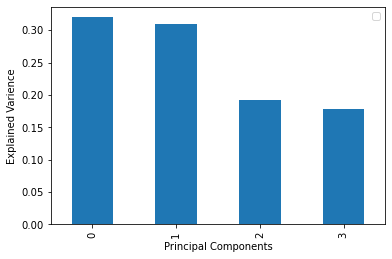

In [33]:
import matplotlib.pyplot as plt
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience');

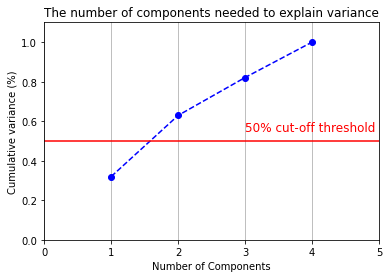

In [34]:
# plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 6, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.5, color='r', linestyle='-')
plt.text(3, 0.55, '50% cut-off threshold', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

#### Apply PCA n_component = 2

In [35]:
X_train_cv_pca = []
X_val_cv_pca = []

pca_new = PCA(n_components=2)
for i in range(len(X_train_cv)):    
    X_train_cv_pca.append(pd.DataFrame(pca_new.fit_transform(X_train_cv[i].iloc[:, :4])))
    X_val_cv_pca.append(pd.DataFrame(pca_new.transform(X_val_cv[i].iloc[:, :4])))

In [36]:
for i in range(len(X_train_cv)):
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_credit_card = X_train_cv[i].loc[:, 'payment_type_credit_card'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_debit_card = X_train_cv[i].loc[:, 'payment_type_debit_card'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_voucher = X_train_cv[i].loc[:, 'payment_type_voucher'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_boleto = X_train_cv[i].loc[:, 'payment_type_boleto'])
       
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_credit_card = X_val_cv[i].loc[:, 'payment_type_credit_card'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_debit_card = X_val_cv[i].loc[:, 'payment_type_debit_card'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_voucher = X_val_cv[i].loc[:, 'payment_type_voucher'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_boleto = X_val_cv[i].loc[:, 'payment_type_boleto'])


In [37]:
X_val_cv_pca[0].head()

,0,1,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_boleto
0,-1.136136,-0.660574,1,0,0,0
1,-0.402720,0.069010,1,0,0,0
2,-0.362986,0.124730,1,0,0,0
3,2.040734,-0.227763,1,0,0,0
4,-0.147724,1.263423,1,0,0,0


### Scale data using min max scaler

In [38]:
for i in range(len(X_train_cv_pca)):
    scaler = MinMaxScaler()
    X_train_cv_pca[i].loc[:, X_train_cv_pca[i].columns] = scaler.fit_transform(X_train_cv_pca[i].loc[:, X_train_cv_pca[i].columns])
    X_val_cv_pca[i].loc[:, X_val_cv_pca[i].columns] = scaler.transform(X_val_cv_pca[i].loc[:, X_val_cv_pca[i].columns])
    


In [39]:
X_val_cv_pca[0].describe()

,0,1,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_boleto
count,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000
mean,0.431008,0.423595,0.757991,0.018265,0.012557,0.211187
std,0.138217,0.141533,0.428544,0.133984,0.111416,0.408384
min,0.024525,-0.028512,0.000000,0.000000,0.000000,0.000000
25%,0.327242,0.338519,1.000000,0.000000,0.000000,0.000000
50%,0.412516,0.403446,1.000000,0.000000,0.000000,0.000000
75%,0.518833,0.509839,1.000000,0.000000,0.000000,0.000000
max,1.083376,0.977658,1.000000,1.000000,1.000000,1.000000


## Model
K-Means dengan Silhouette Coefficient

### PCA K-Means

In [40]:
X_train_cv_pca[0].iloc[:, :]

,0,1,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_boleto
0,0.919487,0.519019,1.0,0.0,0.0,0.0
1,0.316910,0.378464,0.0,1.0,0.0,0.0
2,0.370895,0.421047,1.0,0.0,0.0,0.0
3,0.595273,0.342422,1.0,0.0,0.0,0.0
4,0.360362,0.433785,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3495,0.467356,0.327855,1.0,0.0,0.0,0.0
3496,0.531667,0.128468,1.0,0.0,0.0,0.0
3497,0.341645,0.391353,0.0,0.0,0.0,1.0
3498,0.304260,0.347671,1.0,0.0,0.0,0.0


In [41]:
range_n_clusters = [x+2  for x in range(9)]
train_sil_val = {2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[]}

In [42]:

for df in X_train_cv_pca:
    for n_clusters in range_n_clusters:
        # KMeans clustering
        km = KMeans(n_clusters=n_clusters, random_state=30)
        y_train_predict = km.fit_predict(df)

        # Silhouette score
        silhouette_val = silhouette_score(df, y_train_predict)
        train_sil_val[n_clusters].append(silhouette_val)

In [43]:
res_n_clus = []
res_sil = []
# Average silhoette coef
for key, values in train_sil_val.items():    
    print("n_cluster:",key," avg silhouette coef:", sum(values)/len(values))
    res_n_clus.append(key)
    res_sil.append(sum(values)/len(values))
    

n_cluster: 2  avg silhouette coef: 0.791772659775511
n_cluster: 3  avg silhouette coef: 0.8232852265602613
n_cluster: 4  avg silhouette coef: 0.8350099295328508
n_cluster: 5  avg silhouette coef: 0.5162045909755342
n_cluster: 6  avg silhouette coef: 0.5172895672685872
n_cluster: 7  avg silhouette coef: 0.5176471717981724
n_cluster: 8  avg silhouette coef: 0.42237086661486944
n_cluster: 9  avg silhouette coef: 0.42234502431157805
n_cluster: 10  avg silhouette coef: 0.4415474371030804


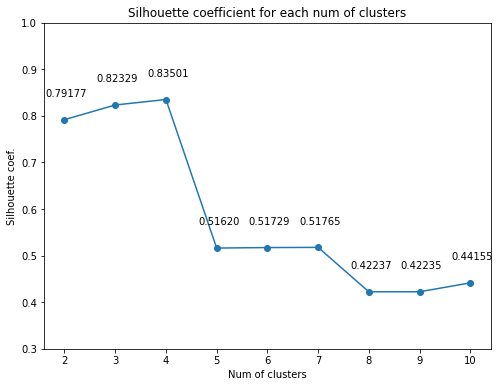

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_ylim(.3,1)
plt.plot(res_n_clus, res_sil, marker='o')
for i,j in zip(res_n_clus,res_sil):
    ax.annotate(str(f"{j:.5f}"),xy=(i-.37,j+0.05))
plt.xlabel('Num of clusters')
plt.xticks(res_n_clus)
plt.ylabel('Silhouette coef.')
# plt.yticks(y_tic)
plt.title('Silhouette coefficient for each num of clusters')
plt.show()

### Apply PCA K-Means to Train and Validation Dataset

In [45]:
val_sil_val = {1:None, 2:None, 3:None, 4:None, 5:None}

In [46]:
X_val_cv_pca[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   0                         876 non-null    float64
 1   1                         876 non-null    float64
 2   payment_type_credit_card  876 non-null    float64
 3   payment_type_debit_card   876 non-null    float64
 4   payment_type_voucher      876 non-null    float64
 5   payment_type_boleto       876 non-null    float64
dtypes: float64(6)
memory usage: 41.2 KB


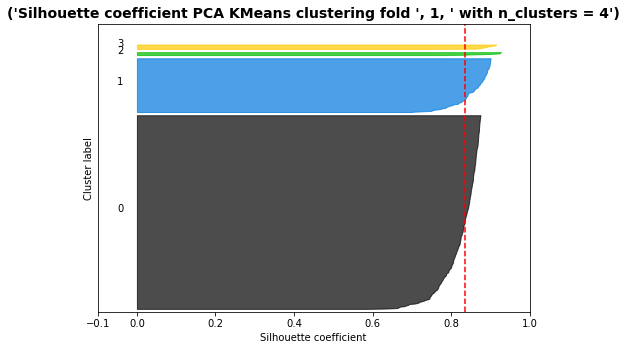

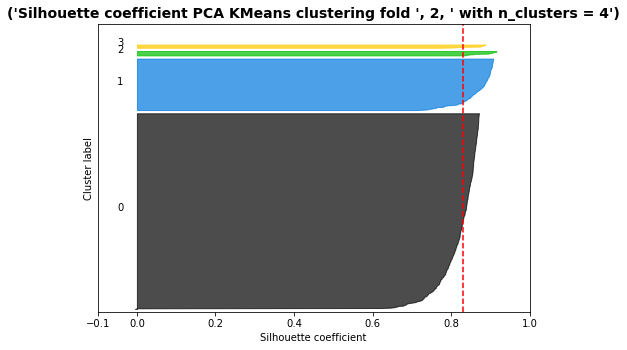

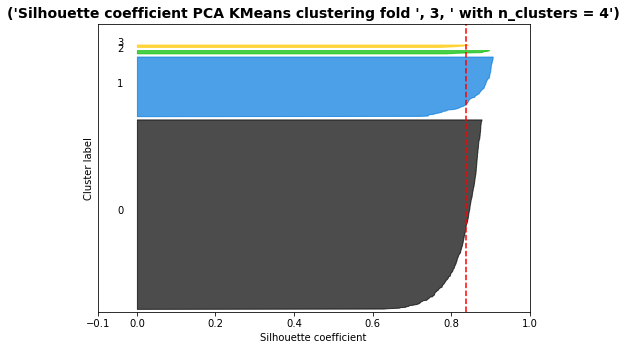

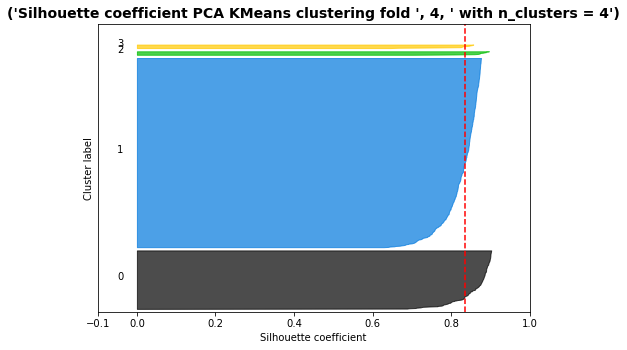

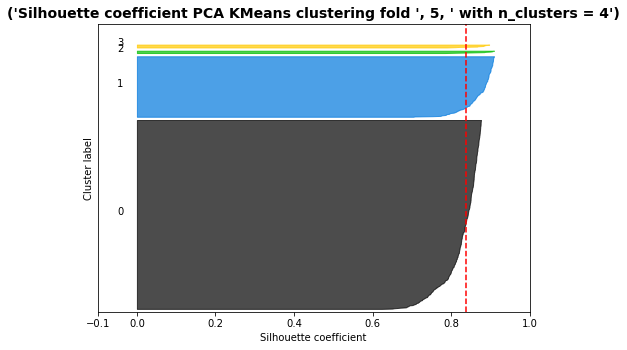

In [48]:
selected_n_clus = 4
for idx in range(len(X_val_cv_pca)):
    # KMeans clustering
    km_val = KMeans(n_clusters=selected_n_clus, random_state=30)
    km_val.fit(X_train_cv_pca[idx])
    y_val_predict = km_val.predict(X_val_cv_pca[idx])
    y_train_predict = km_val.predict(X_train_cv_pca[idx])

    # Silhouette score
    silhouette_val = silhouette_score(X_val_cv_pca[idx], y_val_predict)
    val_sil_val[idx+1] = silhouette_val
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_val_cv_pca[idx], y_val_predict)
    
    # Create figure
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_val_cv_pca[idx]) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(selected_n_clus):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_val_predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / selected_n_clus)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_val, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette coefficient PCA KMeans clustering fold ",idx+1," with n_clusters = %d" % selected_n_clus), fontsize=14, fontweight='bold')

    plt.show()

    # tambah kolom kluster dataset val
    y_val_cv[idx].loc[:, 'cluster'] = pd.Series(y_val_predict)
    #y_val_cv[idx].loc[:, 'customer_unique_id'] = X_val_cv[i].loc[:, 'customer_unique_id']
    
    # tambah kolom kluster dataset train
    y_train_cv[idx].loc[:, 'cluster'] = pd.Series(y_train_predict)
    #y_train_cv[idx].loc[:, 'customer_unique_id'] = X_train_cv[i].loc[:, 'customer_unique_id']

In [49]:
# Average silhoette coef
for key, values in val_sil_val.items():
    print("fold:",key,"silhouette coef:", values)

fold: 1 silhouette coef: 0.8344719603726564
fold: 2 silhouette coef: 0.829919956107309
fold: 3 silhouette coef: 0.8366961788135806
fold: 4 silhouette coef: 0.8343261388324557
fold: 5 silhouette coef: 0.8391905988879903


In [50]:
y_val_cv[0].loc[:, 'cluster'].value_counts()

0    664
1    185
3     16
2     11
Name: cluster, dtype: int64

## Collaborative Filtering

### Rating prediction  function based on user similarity

In [51]:
# prediction rating function based on num of neighbors
def predict_rating(activeUser, itemPredicted, rating_matrix, user_sim, selection_mode = 'neighbors', n=1):
    pembilang = []
    res = None
    penyebut = 0.0001 # to avoid division by zero, penyebut assign with 0.0001
    sim_avg = [] # similarity average
    
    # check selection mode
    if selection_mode == 'neighbors':
        i = 0
        while (i < n) and (i < len(user_sim)):           
            # rbp: rating user b for product p (predicted product)
            rbp = rating_matrix.loc[user_sim.keys()[i], itemPredicted]

            # avg_rb: average rating user b
            avg_rb = rating_matrix.loc[user_sim.keys()[i]].mean()

            # check if similarity is None
            if not math.isnan(user_sim.values[i]):
                pembilang.append(user_sim.values[i] * (rbp - avg_rb))
                penyebut += user_sim.values[i]
                sim_avg.append(user_sim.values[i])
                i += 1
                
            else:
                i += 1
    elif selection_mode == 'treshold':
            for i in range(len(user_sim)):
                # treshold user selection
                if user_sim.values[i] >= n:            
                    # rbp: rating user b for product p (predicted product)
                    rbp = rating_matrix.loc[user_sim.keys()[i], itemPredicted]

                    # avg_rb: average rating user b
                    avg_rb = rating_matrix.loc[user_sim.keys()[i]].mean()
                    pembilang.append(user_sim.values[i] * (rbp - avg_rb))
                    penyebut += user_sim.values[i]
                    sim_avg.append(user_sim.values[i])
                    
    res = rating_matrix.loc[activeUser].mean() + (sum(pembilang) / penyebut)
    avg_sim = (sum(sim_avg)/len(sim_avg))
    return res, avg_sim
    

### Predict user rating  function based on user similarity

In [52]:
def predict_user_rating(cust_id, rating_matrix, selection_mode, n):    
    
    # get rated product from active user
    prod = dict(rating_matrix.loc[cust_id].notnull())
    ratedProdList = [key for key, val in prod.items() if val == True]

    # get un-rated product        
    predictProdList = [key for key, val in prod.items() if val == False]

    # dict for save predict data
    predicted_prod = {'predicted_prod_id': [], 'predicted_rating': []}
    
    avg_sim_users = []

    for predictItem in predictProdList:
        # get user who have rated predicted item 
        user1 = list(rating_matrix[rating_matrix[predictItem].notnull()].index)

        # skip loop if no user rated predicted item
        if len(user1) <= 0:
            continue

        # get user who rated predicted item
        dftmp = rating_matrix.loc[user1]

        # get user who rated predicted item and rated same item with active user
        user2 = []
        for product in ratedProdList:
            a = list(dftmp[dftmp[product].notnull()].index)
            if a not in user2:
                for userA in a:
                    user2.append(userA)

        dftmp2 = rating_matrix.loc[[cust_id] + user2]  

        # improve sparsity problem by fill null with average value from all neighbors
        userAvgTmp = dftmp2.mean(axis=1)
        neighbors_avg = userAvgTmp.mean()
        dftmp2.fillna(neighbors_avg, inplace=True)
        
        # calc similarity with pearson correlation    
        # user_sim = dftmp2.T.corr().iloc[1:, 0] 
        
        # calc similarity with cosine similarity    
        sim_tmp = 1-pairwise_distances(dftmp2, metric='cosine')
        user_sim = pd.Series(sim_tmp[0][1:], index=dftmp2.index[1:])
        
        # remove active user from user_sim
        if cust_id in user_sim.index:            
            user_sim.drop(cust_id, inplace=True)
        # user_sim.sort_values(ascending=False, inplace=True)        
        
        # check if user_sim is empty
        if len(user_sim) != 0:
            # predict rating
            rating, avg_sim = predict_rating(cust_id, predictItem, rating_matrix, user_sim, selection_mode, n)
            predicted_prod['predicted_rating'].append(rating)
            predicted_prod['predicted_prod_id'].append(predictItem)
            avg_sim_users.append(avg_sim)
    avg_sim_val = sum(avg_sim_users)/len(avg_sim_users)
    return predicted_prod, avg_sim_val

### Recommender system evaluation function

In [53]:
# evaluation based on rating prediction with memory-based
def rs_user_evaluation(cust_id, userItemMatrix, selection_mode, n):
    # get product id from active user    
    prod = dict(userItemMatrix.loc[cust_id, :].notnull())
    ratedProdList = [key for key, val in prod.items() if val == True]
    
    # get actual rating from rated product
    prod = dict(userItemMatrix.loc[cust_id])
    actualRating = [val for key, val in prod.items() if key in ratedProdList]
    
    # list to store predicted rating
    predictedRating = []
    
    avg_sims = []
    
    for ratedItem in ratedProdList:
        # get user who have rated predicted item 
        user1 = list(userItemMatrix[userItemMatrix[ratedItem].notnull()].index)

        # skip loop if no user rated predicted item
        if len(user1) <= 0:
            continue

        # get user who rated predicted item
        dftmp = userItemMatrix.loc[user1]

        # get user who rated predicted item and rated same item with active user
        user2 = []
        for product in ratedProdList:
            a = list(dftmp[dftmp[product].notnull()].index)
            if a not in user2:
                for userA in a:
                    user2.append(userA)

        dftmp2 = userItemMatrix.loc[[cust_id] + user2]      
        # improve sparsity problem by fill null with average value from all neighbors
        userAvgTmp = dftmp2.mean(axis=1)
        neighbors_avg = userAvgTmp.mean()
        dftmp2.fillna(neighbors_avg, inplace=True)
        
        # calc similarity with pearson correlation    
        # user_sim = dftmp2.T.corr().iloc[1:, 0] 
        
        sim_tmp = 1-pairwise_distances(dftmp2, metric='cosine')
        user_sim = pd.Series(sim_tmp[0][1:], index=dftmp2.index[1:])

        # remove active user from user_sim
        if cust_id in user_sim.index:            
            user_sim.drop(cust_id, inplace=True)
        # user_sim.sort_values(ascending=False, inplace=True)        
        
        # check if user_sim is empty
        if len(user_sim) != 0:
            # predict rating
            rating, avg_sim = predict_rating(cust_id, ratedItem, userItemMatrix, user_sim, selection_mode, n)
            predictedRating.append(rating)
            avg_sims.append(avg_sim)
        else: # if empty then append None to predicted rating
            predictedRating.append(None)
            avg_sims.append(0)
    
    avg_sim_users = sum(avg_sims)/ len(avg_sims)
    
    # null value check
    if None in predictedRating:
        # remove null value from predictedRating and actual rating
        nullIdx = [i for i, val in enumerate(predictedRating) if not val]
        actualRatingClean = [val for i, val in enumerate(actualRating) if i not in nullIdx]
        predictedRatingClean = [val for i, val in enumerate(predictedRating) if i not in nullIdx]
    else:
        actualRatingClean = actualRating
        predictedRatingClean = predictedRating
    
    # rmse & mae calculation
    if (len(actualRatingClean) != 0) or (len(predictedRatingClean) != 0):
        rmse = mean_squared_error(actualRatingClean, predictedRatingClean, squared=False)
        mae = mean_absolute_error(actualRatingClean, predictedRatingClean)
        
        # dataframe result
        res_df = pd.DataFrame(ratedProdList, columns=['product_id'])
        res_df['predicted_rating'] = predictedRating
        res_df['actual_rating'] = actualRating
        # print(res_df['predicted_rating'].count(),' out of ',len(res_df),' items can be predicted:',(res_df['predicted_rating'].count()/len(res_df))*100,'%')
        n_item_percentage = (res_df['predicted_rating'].count()/len(res_df))*100
    else:
        rmse = None
        mae = None
        res_df = pd.DataFrame()
        n_item_percentage = 0
    return rmse, mae, res_df, n_item_percentage, avg_sim_users

### Generate n-recommendation function

In [54]:
def get_recommendation(result, n):
    if n != None:
        return pd.DataFrame(result).sort_values('predicted_rating', ascending=False).head(n)
    else:
        return pd.DataFrame(result).sort_values('predicted_rating', ascending=False)

### Example: generate product recommendation for a user

In [55]:
# ambil dataset val
tmp = y_val_cv[0].copy()
df0 = tmp[tmp['cluster'] == 0]

In [56]:
df0.describe(include='all')

,customer_unique_id,cluster
count,664,664.0
unique,664,NaN
top,ae153c43e70fe7ed191a0e437bc5e5b7,NaN
freq,1,NaN
mean,NaN,0.0
std,NaN,0.0
min,NaN,0.0
25%,NaN,0.0
50%,NaN,0.0
75%,NaN,0.0


In [57]:
df0_rating = pd.merge(df0, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])
df0_rating.head()

,customer_unique_id,cluster,product_id,rating
0,bee8c71dfec2314e63b7ef0e2ce70bdd,0,5581bb179770e44255d6bb9b9e1bcca9,4
1,4841d5835d0ab4894f2b0a0ac60aa49a,0,bc911e68db068530ee4d709f33920330,4
2,4841d5835d0ab4894f2b0a0ac60aa49a,0,a8fe47ad6f852f93cc92c7b408687de3,5
3,4841d5835d0ab4894f2b0a0ac60aa49a,0,ac8e7cf3a658f63dc68dd7f3b8b5f97b,5
4,4841d5835d0ab4894f2b0a0ac60aa49a,0,19421075ae0b585f2dc13ff149e2119d,4


In [58]:
df0_rating.describe(include='all')

,customer_unique_id,cluster,product_id,rating
count,1728,1728.0,1728,1728.000000
unique,664,NaN,514,NaN
top,cf7d5df4ee5ebe39ed41f0c5c1584b1c,NaN,cec09725da5ed01471d9a505e7389d37,NaN
freq,12,NaN,50,NaN
mean,NaN,0.0,NaN,4.263889
std,NaN,0.0,NaN,1.016843
min,NaN,0.0,NaN,1.000000
25%,NaN,0.0,NaN,4.000000
50%,NaN,0.0,NaN,5.000000
75%,NaN,0.0,NaN,5.000000


### Pilih user yang memberikan rating kurang dari 2 item

In [59]:
user_freq = dict(df0_rating['customer_unique_id'].value_counts())
user_list = [key for key, val in user_freq.items() if val < 2]
len(user_list)

518

In [60]:
idx = df0_rating[df0_rating['customer_unique_id'].isin(user_list)].index
df0_rating.drop(idx, axis=0,inplace=True)
df0_rating.shape

(1210, 4)

#### Generate product recommendation

#### user-item rating matrix

In [61]:
rating_matrix = df0_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')
rating_matrix.shape

(146, 183)

In [62]:
# user example
cust_unique_id = rating_matrix.index

#### Top 10 product recommendation

In [63]:
cust_unique_id[0]

'00115fc7123b5310cf6d3a3aa932699e'

In [64]:
res, avg_sim = predict_user_rating(cust_unique_id[0], rating_matrix, 'neighbors', 20)
print('Average similarity:', avg_sim)
get_recommendation(res, 10)

Average similarity: 0.9978953493651807


,predicted_prod_id,predicted_rating
129,f699b297070aa38aaf3de9639302506a,5.111074
132,f9ce5e5592c6836c379b156a1b043684,4.999950
28,35c4a5bb0f191b77c8900661f047250b,4.999900
101,b18e0067418085fab0785606c86d875c,4.999900
128,f68980d7981fcc92059f42a4fd82fb38,4.999900
78,8f2a61109d01cbda2cc6cdea233b1102,4.999900
51,5df044498554dec765264c2cad9804e6,4.899910
123,ec268f069320a08af47861967e4d7bee,4.888844
13,13e0e6adec3689a4206c6e9385a29003,4.874971
86,a0458f75b62b1e812480c0c915d9b649,4.857057


#### RS evaluation

In [65]:
rmse, mae, result_df, item_predicted_percentage, avg_n_users = rs_user_evaluation(cust_unique_id[0], rating_matrix, 'neighbors',50)
print('RMSE:',rmse)
print('MAE:',mae)
print('Percentage of total rated items that can be predicted:',item_predicted_percentage,'%')
print('Average num of similar users:', avg_n_users)
result_df

RMSE: 0.8476168032025855
MAE: 0.7566342662508823
Percentage of total rated items that can be predicted: 100.0 %
Average num of similar users: 0.9978159617640661


,product_id,predicted_rating,actual_rating
0,008cff0e5792219fae03e570f980b330,3.488422,3.0
1,1a758361b1c10b3ffe3d3373332de319,3.870600,4.0
2,3570caaeaa3f5a1ae76392bb2b4155f9,3.842345,3.0
3,4b5e26931a0b0d3a690a3f520329a975,3.969566,5.0
4,c6336fa91fbd87c359e44f5dca5a90ed,3.943975,5.0
5,c72edc98e7d77f0c4c04ec80730c05f5,4.017787,5.0
6,cb92637d91f8267856d2143b6fc7bd9e,4.400565,4.0
7,d3c044bd42d84a79e3b0c42662806a48,3.967457,3.0
8,d8de812ed5d981fc6a3984f4caa2aa05,4.140379,4.0
9,e44f675b60b3a3a2453ec36421e06f0f,3.958482,3.0


# Result Comparison 

In [ ]:
# list num of neighbors
n_neighbors = [10, 20, 30, 40, 50]

## PCA-KM CF Method

### Evaluate PCA-KM CF all neighbors with val data

In [66]:
avg_rmse_all_neighbors = []
avg_mae_all_neighbors = []

for n_neighbor in n_neighbors:
    avg_rmse_df = []
    avg_mae_df = []
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    for i in range(len(y_val_cv)):    
        rmse_all = []
        mae_all = []
        percentage_all = []
        avg_users_all = []
        tmp = y_val_cv[i].copy()
        n_clus = list(tmp['cluster'].unique())
        for n in n_clus:
            # get data cluster n
            dftmp = tmp[tmp['cluster'] == n]            

            # join with df rating
            df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

            # drop user who only rated below 2 product
            user_freq = dict(df_rating['customer_unique_id'].value_counts())
            user_list = [key for key, val in user_freq.items() if val < 2]
            idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
            df_rating.drop(idx, axis=0,inplace=True)

            # create rating matrix
            rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

            # get user
            cust_unique_id = rating_matrix.index
            for user in cust_unique_id:     
                rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, rating_matrix, 'neighbors', n_neighbor)
                percentage_all.append(item_predicted_percentage)
                avg_users_all.append(avg_n_users)
                rmse_all.append(rmse)
                mae_all.append(mae)

        print('Dataset train:', i)
        print('Avg RMSE:',sum(filter(None, rmse_all)) / len(rmse_all))
        print('Avg MAE:',sum(filter(None, mae_all)) / len(mae_all))
        print('Avg Percentage:',sum(filter(None, percentage_all)) / len(percentage_all))
        print('Avg Similarity Users:',sum(filter(None, avg_users_all)) / len(avg_users_all))
        print('############################################################')
        
        avg_rmse_df.append(sum(filter(None, rmse_all)) / len(rmse_all))
        avg_mae_df.append(sum(filter(None, mae_all)) / len(mae_all))
        
    print('Avg RMSE dataset train with n_neighbors ',n_neighbor,':',sum(filter(None, avg_rmse_df)) / len(avg_rmse_df))
    print('Avg MAE dataset train with n_neighbors ',n_neighbor,':',sum(filter(None, avg_mae_df)) / len(avg_mae_df))
    
    avg_rmse_all_neighbors.append(sum(filter(None, avg_rmse_df)) / len(avg_rmse_df))
    avg_mae_all_neighbors.append(sum(filter(None, avg_mae_df)) / len(avg_mae_df))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
Dataset train: 0
Avg RMSE: 0.7681615980229939
Avg MAE: 0.6614402751537621
Avg Percentage: 86.64183855360325
Avg Similarity Users: 0.8648763767795612
############################################################
Dataset train: 1
Avg RMSE: 0.7853883879877448
Avg MAE: 0.6731682665950974
Avg Percentage: 87.2322453430408
Avg Similarity Users: 0.8705645936877175
############################################################
Dataset train: 2
Avg RMSE: 0.7519516372731733
Avg MAE: 0.6451692692320256
Avg Percentage: 88.34173694000283
Avg Similarity Users: 0.8817084748187591
############################################################
Dataset train: 3
Avg RMSE: 0.7307143740363712
Avg MAE: 0.6249677780434846
Avg Percentage: 85.75799430771802
Avg Similarity Users: 0.8558800115198707
############################################################
Dataset train: 4
Avg RMSE: 0.7727365221559431
Avg MAE: 0.6642409778955658
Avg Percentage: 86.4456834613902

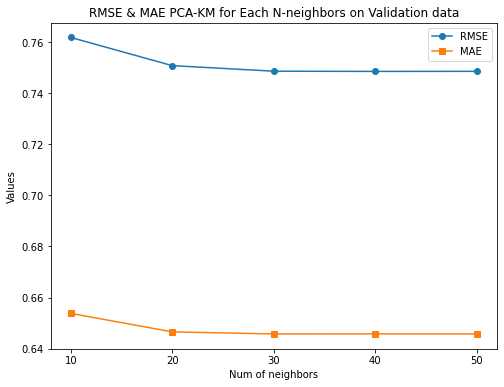

In [79]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE PCA-KM for Each N-neighbors on Validation data')
plt.legend()
plt.show()

### Evaluate PCA-KM CF all neighbors with test data

#### Apply PCA

In [68]:
X_test.shape

(1094, 9)

In [69]:
X_test.iloc[:, :4].head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng
0,2.407572,-0.810558,-0.323816,-1.667628
1,2.407572,2.576152,-1.865278,-1.662286
2,-0.617273,-1.339230,-0.442435,-0.121182
3,-0.617273,1.481692,0.107947,0.075322
4,-0.617273,-1.036220,0.934648,2.278258


In [70]:
X_test.describe(include='all')

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
count,1.094000e+03,1.094000e+03,1.094000e+03,1.094000e+03,1094.0,1094.000000,1094.000000,1094.00000,1094.000000
mean,1.035126e-17,-2.238967e-16,8.482449e-16,2.023239e-15,1.0,0.232176,0.735832,0.02011,0.011883
std,1.000457e+00,1.000457e+00,1.000457e+00,1.000457e+00,0.0,0.422413,0.441091,0.14044,0.108409
min,-6.172731e-01,-1.624277e+00,-2.566053e+00,-3.045081e+00,1.0,0.000000,0.000000,0.00000,0.000000
25%,-6.172731e-01,-7.807911e-01,-4.398043e-01,-4.790105e-01,1.0,0.000000,0.000000,0.00000,0.000000
50%,-6.172731e-01,-2.778770e-01,-1.929006e-01,-2.998085e-02,1.0,0.000000,1.000000,0.00000,0.000000
75%,1.389383e-01,5.323901e-01,4.033885e-01,8.460640e-01,1.0,0.000000,1.000000,0.00000,0.000000
max,3.163784e+00,3.111653e+00,3.042150e+00,2.739117e+00,1.0,1.000000,1.000000,1.00000,1.000000


In [71]:
X_test_pca = pd.DataFrame(pca_new.transform(X_test.iloc[:, :4]))

In [72]:
X_test_pca = X_test_pca.assign(payment_type_credit_card = X_test.loc[:, 'payment_type_credit_card'])
X_test_pca = X_test_pca.assign(payment_type_debit_card = X_test.loc[:, 'payment_type_debit_card'])
X_test_pca = X_test_pca.assign(payment_type_voucher = X_test.loc[:, 'payment_type_voucher'])
X_test_pca = X_test_pca.assign(payment_type_boleto = X_test.loc[:, 'payment_type_boleto'])

In [73]:
X_test_pca.shape

(1094, 6)

#### Scaling Test Dataset

In [74]:
X_test_pca[X_test_pca.columns] = scaler.transform(X_test_pca)

#### Apply K-Means

Dataset test silhouette coef: 0.845154364000818


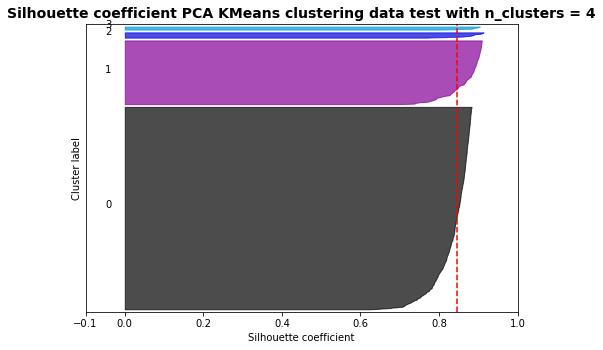

In [75]:
# KMeans clustering
y_test_predict = km_val.predict(X_test_pca)

# Silhouette score
silhouette_val = silhouette_score(X_test_pca, y_test_predict)
print('Dataset test silhouette coef:', silhouette_val)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_test_pca, y_test_predict)

# Create figure
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_test_pca) + (selected_n_clus + 1) * 10])
y_lower = 10
for i in range(selected_n_clus):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_test_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_val, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title(("Silhouette coefficient PCA KMeans clustering data test with n_clusters = %d" % selected_n_clus), fontsize=14, fontweight='bold')

plt.show()

# tambah kolom kluster
y_test['cluster'] = pd.Series(y_test_predict)


#### Evaluate PCA-KM CF test

In [76]:
avg_rmse_all_neighbors_test1 = []
avg_mae_all_neighbors_test1 = []
for n_neighbor in n_neighbors:
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    rmse_all_test1 = []
    mae_all_test1 = []
    percentage_all_test1 = []
    avg_users_all_test1 = []

    tmp = y_test.copy()
    n_clus = list(tmp['cluster'].unique())
    for n in n_clus:
        # get data cluster n
        dftmp = tmp[tmp['cluster'] == n]


        # join with df rating
        df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

        # drop user who only rated below 2 product
        user_freq = dict(df_rating['customer_unique_id'].value_counts())
        user_list = [key for key, val in user_freq.items() if val < 2]
        idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
        df_rating.drop(idx, axis=0,inplace=True)

        # create rating matrix
        test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

        # get user
        cust_unique_id = test_rating_matrix.index
        for user in cust_unique_id:
            rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
            percentage_all_test1.append(item_predicted_percentage)
            avg_users_all_test1.append(avg_n_users)
            rmse_all_test1.append(rmse)
            mae_all_test1.append(mae)

    rmse1 = sum(filter(None, rmse_all_test1)) / len(rmse_all_test1)
    mae1 = sum(filter(None, mae_all_test1)) / len(mae_all_test1)
    
    avg_rmse_all_neighbors_test1.append(rmse1)
    avg_mae_all_neighbors_test1.append(mae1)
    print('############################################################')
    print('Dataset test:')
    print('Avg RMSE:',rmse1)
    print('Avg MAE:',mae1)
    print('Avg Percentage:',sum(filter(None, percentage_all_test1)) / len(percentage_all_test1))
    print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test1)) / len(avg_users_all_test1))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7718062651856156
Avg MAE: 0.6626521178543732
Avg Percentage: 88.03827669707493
Avg Num of Similar Users: 0.8788839276677758
~~~~~~~~~~~~~ Num of neigbors :  20  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7574715051261616
Avg MAE: 0.6529668337381309
Avg Percentage: 88.03827669707493
Avg Num of Similar Users: 0.87889269760343
~~~~~~~~~~~~~ Num of neigbors :  30  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7530450892181813
Avg MAE: 0.6510499314090272
Avg Percentage: 88.03827669707493
Avg Num of Similar Users: 0.8788957801393528
~~~~~~~~~~~~~ Num of neigbors :  40  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7530429058110321
Avg MAE: 0.6516585170294231
Avg Percentage: 8

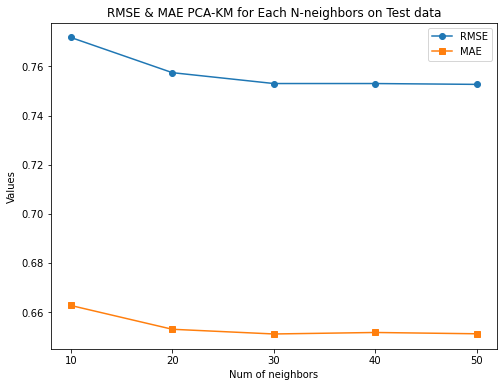

In [78]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors_test1, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors_test1, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE PCA-KM for Each N-neighbors on Test data')
plt.legend()
plt.show()

In [ ]:
# rmse_all_test1 = []
# mae_all_test1 = []
# percentage_all_test1 = []
# avg_users_all_test1 = []

# start_time = time.time()
# tmp = y_test.copy()
# n_clus = list(tmp['cluster'].unique())
# for n in n_clus:
#     # get data cluster n
#     dftmp = tmp[tmp['cluster'] == n]
#     # dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)
    
#     # join with df rating
#     df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])
    
#     # drop user who only rated below 2 product
#     user_freq = dict(df_rating['customer_unique_id'].value_counts())
#     user_list = [key for key, val in user_freq.items() if val < 2]
#     idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
#     df_rating.drop(idx, axis=0,inplace=True)

#     # create rating matrix
#     test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

#     # get user
#     cust_unique_id = test_rating_matrix.index
#     for user in cust_unique_id:
#         rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', 20)
#         percentage_all_test1.append(item_predicted_percentage)
#         avg_users_all_test1.append(avg_n_users)
#         rmse_all_test1.append(rmse)
#         mae_all_test1.append(mae)

# # end of execution time
# end_time = time.time()
# exec_time_test1 = (end_time - start_time)
# rmse1 = sum(filter(None, rmse_all_test1)) / len(rmse_all_test1)
# mae1 = sum(filter(None, mae_all_test1)) / len(mae_all_test1)
# print('############################################################')
# print('Dataset test:')
# print('Avg RMSE:',rmse1)
# print('Avg MAE:',mae1)
# print('Execution time: ',exec_time_test1)
# print('Avg Percentage:',sum(filter(None, percentage_all_test1)) / len(percentage_all_test1))
# print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test1)) / len(avg_users_all_test1))

## K-Means CF Method

### Evaluate KM CF all neighbors with val data

#### Create new cross validation

In [80]:
X_train_cv_km = []
X_val_cv_km = []
y_train_cv_km = []
y_val_cv_km = []

i = 0
for train_index, val_index in kf.split(X_train2):
    X_train_cv_km.append(X_train2.iloc[train_index,:])
    X_val_cv_km.append(X_train2.iloc[val_index,:])
    y_train_cv_km.append(y_train2.iloc[train_index,:])
    y_val_cv_km.append(y_train2.iloc[val_index,:])
    
    
    X_train_cv_km[i].reset_index(drop=True, inplace=True)
    y_train_cv_km[i].reset_index(drop=True, inplace=True)
    X_val_cv_km[i].reset_index(drop=True, inplace=True)
    y_val_cv_km[i].reset_index(drop=True, inplace=True)
    
    i += 1

In [81]:
X_train.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,-0.634538,-1.166150,-0.449417,-0.005827,1.0,0,1,0,0
1,1.729071,3.140194,0.901737,2.245756,1.0,0,1,0,0
2,-0.634538,-0.641016,-0.440324,-0.014906,1.0,0,0,1,0
3,-0.634538,0.142483,-0.393583,0.032726,1.0,0,1,0,0
4,0.153331,0.593210,1.074710,0.961564,1.0,0,1,0,0


#### Scaling data

In [82]:
for i in range(len(X_val_cv)):
    scaler_km = MinMaxScaler()
    X_train_cv_km[i].iloc[:, :] = scaler_km.fit_transform(X_train_cv_km[i].iloc[:, :])
    X_val_cv_km[i].iloc[:, :] = scaler_km.transform(X_val_cv_km[i].iloc[:, :])

#### Apply K-Means to validation dataset

In [83]:
val_sil_val = {1:None, 2:None, 3:None, 4:None, 5:None}

In [84]:
X_val_cv_km[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_payment_installments  876 non-null    float64
 1   total_payment_value         876 non-null    float64
 2   geolocation_lat             876 non-null    float64
 3   geolocation_lng             876 non-null    float64
 4   total_payment_sequential    876 non-null    float64
 5   payment_type_boleto         876 non-null    float64
 6   payment_type_credit_card    876 non-null    float64
 7   payment_type_debit_card     876 non-null    float64
 8   payment_type_voucher        876 non-null    float64
dtypes: float64(9)
memory usage: 61.7 KB


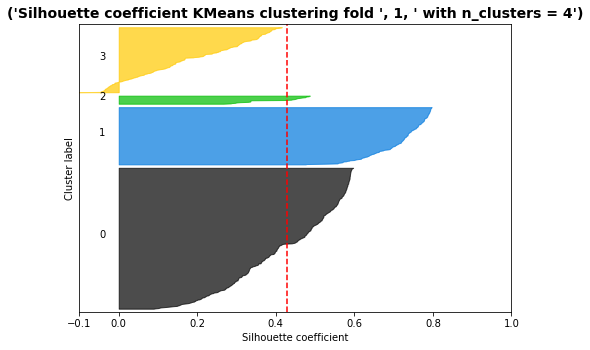

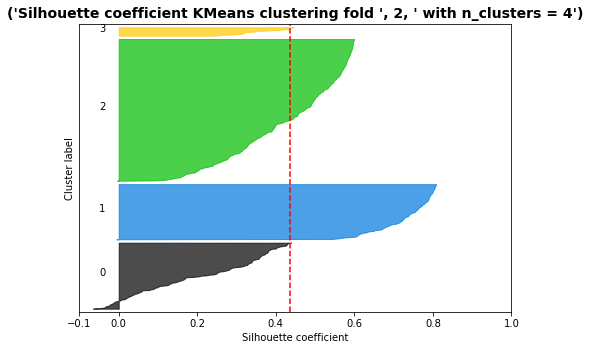

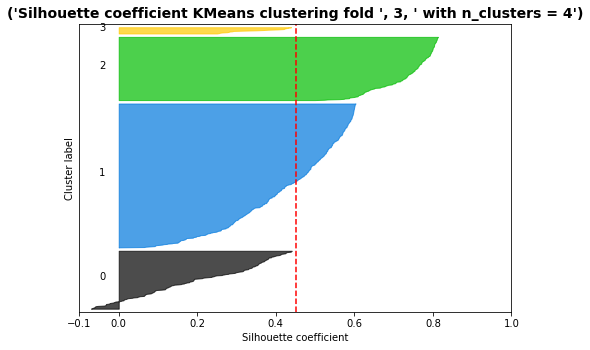

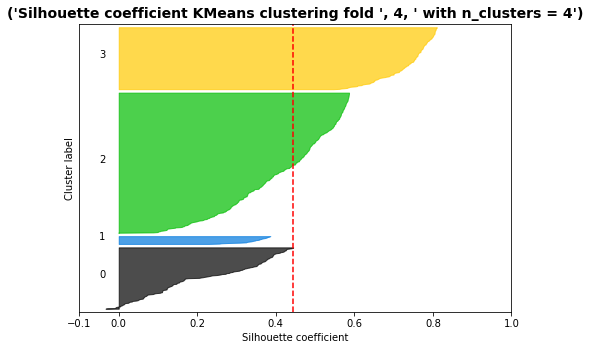

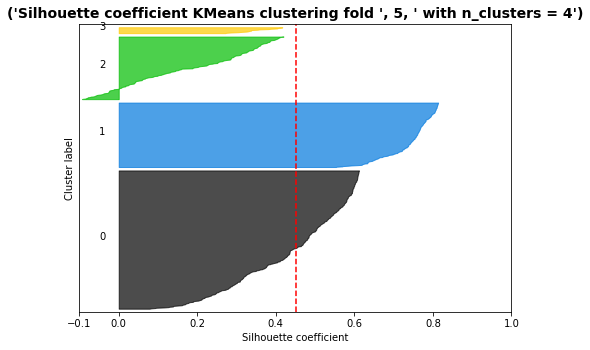

In [85]:
for idx in range(len(X_val_cv_km)):
    # KMeans clustering
    km_val2 = KMeans(n_clusters=selected_n_clus, random_state=30)
    km_val2.fit(X_train_cv_km[idx])
    y_val_km_predict = km_val2.predict(X_val_cv_km[idx])    

    # Silhouette score
    silhouette_val = silhouette_score(X_val_cv_km[idx], y_val_km_predict)
    val_sil_val[idx+1] = silhouette_val
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_val_cv_km[idx], y_val_km_predict)
       
    # Create figure
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_val_cv_km[idx]) + (selected_n_clus + 1) * 10])
    y_lower = 10
    for i in range(selected_n_clus):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_val_km_predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / selected_n_clus)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_val, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette coefficient KMeans clustering fold ",idx+1," with n_clusters = %d" % selected_n_clus), fontsize=14, fontweight='bold')

    plt.show()

    # tambah kolom kluster dataset val
    y_val_cv_km[idx].loc[:, 'cluster'] = pd.Series(y_val_km_predict)
    

In [86]:
# Average silhoette coef
for key, values in val_sil_val.items():
    print("fold:",key,"silhouette coef:", values)

fold: 1 silhouette coef: 0.4285582448367277
fold: 2 silhouette coef: 0.435719347400756
fold: 3 silhouette coef: 0.4522194776155601
fold: 4 silhouette coef: 0.4431816097089556
fold: 5 silhouette coef: 0.4515171438361322


In [87]:
y_val_cv_km[0].loc[:, 'cluster'].value_counts()

0    454
3    210
1    185
2     27
Name: cluster, dtype: int64

#### Evaluate KMCF all neighbors with dataset val

In [92]:
avg_rmse_all_neighbors_km = []
avg_mae_all_neighbors_km = []

for n_neighbor in n_neighbors:
    avg_rmse_all_km = []
    avg_mae_all_km = []
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    for i in range(len(y_val_cv_km)):
        rmse_all = []
        mae_all = []
        percentage_all = []
        avg_users_all = []

        tmp = y_val_cv_km[i].copy()
        n_clus = list(tmp['cluster'].unique())
        for n in n_clus:
            # get data cluster n
            dftmp = tmp[tmp['cluster'] == n]
            #dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

            # join with df rating
            df_rating_km = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

            # drop user who only rated below 2 product
            user_freq = dict(df_rating_km['customer_unique_id'].value_counts())
            user_list = [key for key, val in user_freq.items() if val < 2]
            idx = df_rating_km[df_rating_km['customer_unique_id'].isin(user_list)].index
            df_rating_km.drop(idx, axis=0,inplace=True)

            # create rating matrix
            rating_matrix_km = df_rating_km.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

            # get user
            cust_unique_id = rating_matrix_km.index
            for user in cust_unique_id:
                rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, rating_matrix_km, 'neighbors', n_neighbor)
                percentage_all.append(item_predicted_percentage)
                avg_users_all.append(avg_n_users)
                rmse_all.append(rmse)
                mae_all.append(mae)

        print('############################################################')
        print('Dataset validation:', i)
        print('Avg RMSE:',sum(filter(None, rmse_all)) / len(rmse_all))
        print('Avg MAE:',sum(filter(None, mae_all)) / len(mae_all))
        print('Avg Percentage:',sum(filter(None, percentage_all)) / len(percentage_all))
        print('Avg Num of Similar Users:',sum(filter(None, avg_users_all)) / len(avg_users_all))

        avg_rmse_all_km.append(sum(filter(None, rmse_all)) / len(rmse_all))
        avg_mae_all_km.append(sum(filter(None, mae_all)) / len(mae_all))
                
    print('Avg RMSE dataset train with n_neighbors ',n_neighbor,':',sum(filter(None, avg_rmse_all_km)) / len(avg_rmse_all_km))
    print('Avg MAE dataset train with n_neighbors ',n_neighbor,':',sum(filter(None, avg_mae_all_km)) / len(avg_mae_all_km))
    
    avg_rmse_all_neighbors_km.append(sum(filter(None, avg_rmse_all_km)) / len(avg_rmse_all_km))
    avg_mae_all_neighbors_km.append(sum(filter(None, avg_mae_all_km)) / len(avg_mae_all_km))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
############################################################
Dataset validation: 0
Avg RMSE: 0.8004411064578857
Avg MAE: 0.6822505845839504
Avg Percentage: 86.42521471398474
Avg Num of Similar Users: 0.8622930621638947
############################################################
Dataset validation: 1
Avg RMSE: 0.8014095806359564
Avg MAE: 0.6853472286842662
Avg Percentage: 87.11639528400889
Avg Num of Similar Users: 0.8690264997832586
############################################################
Dataset validation: 2
Avg RMSE: 0.7772829799067308
Avg MAE: 0.6615597722299538
Avg Percentage: 87.92518496275719
Avg Num of Similar Users: 0.8770714197399856
############################################################
Dataset validation: 3
Avg RMSE: 0.7360522645226535
Avg MAE: 0.6225307336499457
Avg Percentage: 86.41804788213625
Avg Num of Similar Users: 0.862119298413791
############################################################
Dataset v

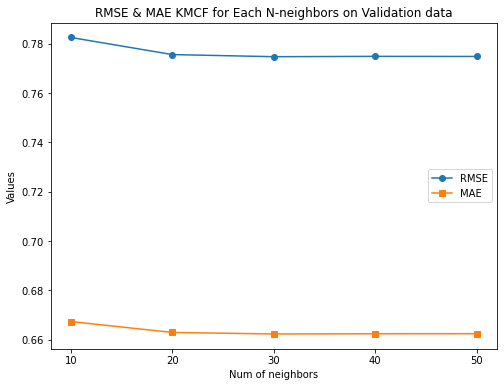

In [120]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors_km, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors_km, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE KMCF for Each N-neighbors on Validation data')
plt.legend()
plt.show()

### Evaluate KM CF all neighbors with test data

In [94]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_payment_installments  1094 non-null   float64
 1   total_payment_value         1094 non-null   float64
 2   geolocation_lat             1094 non-null   float64
 3   geolocation_lng             1094 non-null   float64
 4   total_payment_sequential    1094 non-null   float64
 5   payment_type_boleto         1094 non-null   uint8  
 6   payment_type_credit_card    1094 non-null   uint8  
 7   payment_type_debit_card     1094 non-null   uint8  
 8   payment_type_voucher        1094 non-null   uint8  
dtypes: float64(5), uint8(4)
memory usage: 47.1 KB


#### Scale data

In [95]:
X_test2.iloc[:, :] = scaler_km.transform(X_test2.iloc[:, :])

In [96]:
X_test2.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,0.8,0.171649,0.395220,0.238928,0.0,0.0,1.0,0.0,0.0
1,0.8,0.884235,0.121593,0.239854,0.0,0.0,1.0,0.0,0.0
2,0.0,0.060413,0.374163,0.506760,0.0,0.0,1.0,0.0,0.0
3,0.0,0.653953,0.471862,0.540793,0.0,1.0,0.0,0.0,0.0
4,0.0,0.124168,0.618610,0.922323,0.0,1.0,0.0,0.0,0.0


#### Apply K-Means

Dataset test silhouette coef: 0.4525436420361471


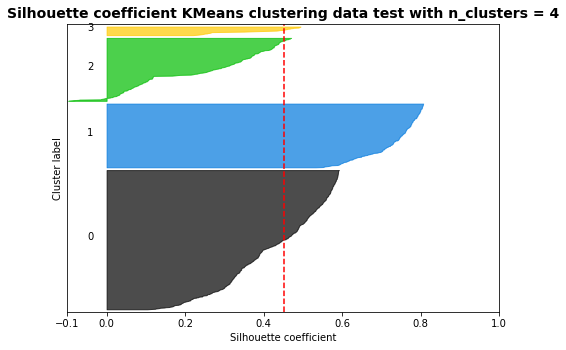

In [97]:
# KMeans clustering
y_test2_predict = km_val2.predict(X_test2)

# Silhouette score
silhouette_val = silhouette_score(X_test2, y_test2_predict)
print('Dataset test silhouette coef:', silhouette_val)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_test2, y_test2_predict)

# Create figure
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_test) + (selected_n_clus + 1) * 10])
y_lower = 10
for i in range(selected_n_clus):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_test2_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / selected_n_clus)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_val, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title(("Silhouette coefficient KMeans clustering data test with n_clusters = %d" % selected_n_clus), fontsize=14, fontweight='bold')

plt.show()

# tambah kolom kluster
y_test2['cluster'] = pd.Series(y_test2_predict)

In [98]:
y_test2['cluster'].value_counts()

0    554
1    254
2    251
3     35
Name: cluster, dtype: int64

#### Evaluate KMCF on test data

In [99]:
avg_rmse_all_neighbors_test2 = []
avg_mae_all_neighbors_test2 = []
for n_neighbor in n_neighbors:
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    rmse_all_test2 = []
    mae_all_test2 = []
    percentage_all_test2 = []
    avg_users_all_test2 = []

    tmp = y_test2.copy()
    n_clus = list(tmp['cluster'].unique())
    for n in n_clus:
        # get data cluster n
        dftmp = tmp[tmp['cluster'] == n]
        # dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

        # join with df rating
        df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

        # drop user who only rated below 2 product
        user_freq = dict(df_rating['customer_unique_id'].value_counts())
        user_list = [key for key, val in user_freq.items() if val < 2]
        idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
        df_rating.drop(idx, axis=0,inplace=True)

        # create rating matrix
        test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

        # get user
        cust_unique_id = test_rating_matrix.index
        for user in cust_unique_id:
            rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
            percentage_all_test2.append(item_predicted_percentage)
            avg_users_all_test2.append(avg_n_users)
            rmse_all_test2.append(rmse)
            mae_all_test2.append(mae)

    
    rmse2 = sum(filter(None, rmse_all_test2)) / len(rmse_all_test2)
    mae2 = sum(filter(None, mae_all_test2)) / len(mae_all_test2)
    
    avg_rmse_all_neighbors_test2.append(rmse2)
    avg_mae_all_neighbors_test2.append(mae2)
    print('############################################################')
    print('Dataset test:')
    print('Avg RMSE:',rmse2)
    print('Avg MAE:',mae2)
    print('Avg Percentage:',sum(filter(None, percentage_all_test2)) / len(percentage_all_test2))
    print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test2)) / len(avg_users_all_test2))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7721829156602452
Avg MAE: 0.6586673030674212
Avg Percentage: 88.05956561321368
Avg Num of Similar Users: 0.8787295212658749
~~~~~~~~~~~~~ Num of neigbors :  20  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7631549260623239
Avg MAE: 0.6539483241883404
Avg Percentage: 88.05956561321368
Avg Num of Similar Users: 0.8787344551499422
~~~~~~~~~~~~~ Num of neigbors :  30  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7623186740807069
Avg MAE: 0.6540873836359992
Avg Percentage: 88.05956561321368
Avg Num of Similar Users: 0.8787363566822886
~~~~~~~~~~~~~ Num of neigbors :  40  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7616963454096842
Avg MAE: 0.6533822850206741
Avg Percentage:

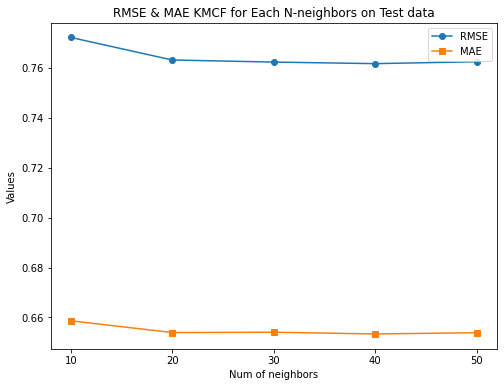

In [100]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors_test2, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors_test2, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE KMCF for Each N-neighbors on Test data')
plt.legend()
plt.show()

## Hierarchical Clustering CF Method

### Evaluate HCCF all neighbors with validation data

#### Create new cross validation

In [101]:
X_train_cv_hac = []
X_val_cv_hac = []
y_train_cv_hac = []
y_val_cv_hac = []

i = 0
for train_index, val_index in kf.split(X_train3):
    X_train_cv_hac.append(X_train3.iloc[train_index,:])
    X_val_cv_hac.append(X_train3.iloc[val_index,:])
    y_train_cv_hac.append(y_train3.iloc[train_index,:])
    y_val_cv_hac.append(y_train3.iloc[val_index,:])
    
    
    X_train_cv_hac[i].reset_index(drop=True, inplace=True)
    y_train_cv_hac[i].reset_index(drop=True, inplace=True)
    X_val_cv_hac[i].reset_index(drop=True, inplace=True)
    y_val_cv_hac[i].reset_index(drop=True, inplace=True)
    
    i += 1

In [102]:
X_train_cv_hac[0].head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,4.0,314.84,-20.3514,-40.4284,1.0,0,1,0,0
1,1.0,67.36,-23.6132,-46.6031,1.0,0,0,1,0
2,1.0,118.64,-23.4996,-46.4730,1.0,0,1,0,0
3,2.0,148.14,-19.9310,-43.9360,1.0,0,1,0,0
4,1.0,119.25,-23.6750,-46.7857,1.0,0,1,0,0


#### Scaling data

In [103]:
for i in range(len(X_val_cv_hac)):
    scaler_hac = MinMaxScaler()
    X_train_cv_hac[i].iloc[:, :] = scaler_hac.fit_transform(X_train_cv_hac[i].iloc[:, :])
    X_val_cv_hac[i].iloc[:, :] = scaler_hac.transform(X_val_cv_hac[i].iloc[:, :])

#### Apply agglomerative hierarchical clustering to validation dataset

In [104]:
val_sil_val = {1:None, 2:None, 3:None, 4:None, 5:None}

In [105]:
X_val_cv_hac[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_payment_installments  876 non-null    float64
 1   total_payment_value         876 non-null    float64
 2   geolocation_lat             876 non-null    float64
 3   geolocation_lng             876 non-null    float64
 4   total_payment_sequential    876 non-null    float64
 5   payment_type_boleto         876 non-null    float64
 6   payment_type_credit_card    876 non-null    float64
 7   payment_type_debit_card     876 non-null    float64
 8   payment_type_voucher        876 non-null    float64
dtypes: float64(9)
memory usage: 61.7 KB


In [106]:
for idx in range(len(X_val_cv_hac)):
    
    # KMeans clustering
    hac = AgglomerativeClustering(n_clusters=selected_n_clus, affinity='euclidean', linkage='ward')
    #hac.fit(X_train_cv_hac[idx])
    y_val_hac_predict = hac.fit_predict(X_val_cv_hac[idx])    

    # Silhouette score
    silhouette_val = silhouette_score(X_val_cv_hac[idx], y_val_hac_predict)
    val_sil_val[idx+1] = silhouette_val
    
    # tambah kolom kluster dataset val
    y_val_cv_hac[idx].loc[:, 'cluster'] = pd.Series(y_val_hac_predict)
    

In [107]:
# Average silhoette coef
for key, values in val_sil_val.items():
    print("fold:",key,"silhouette coef:", values)

fold: 1 silhouette coef: 0.41332264264171276
fold: 2 silhouette coef: 0.4318931273470786
fold: 3 silhouette coef: 0.4227513081400522
fold: 4 silhouette coef: 0.3968149471463533
fold: 5 silhouette coef: 0.40093203846076786


In [108]:
y_val_cv_hac[0].loc[:, 'cluster'].value_counts()

1    459
3    205
2    185
0     27
Name: cluster, dtype: int64

#### Evaluate HCCF on val data

In [121]:
avg_rmse_all_neighbors_hac = []
avg_mae_all_neighbors_hac = []

for n_neighbor in n_neighbors:   
    avg_rmse_all_hac = []
    avg_mae_all_hac = []
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    for i in range(len(y_val_cv_hac)):
        rmse_all = []
        mae_all = []
        percentage_all = []
        avg_users_all = []

        tmp = y_val_cv_hac[i].copy()
        n_clus = list(tmp['cluster'].unique())
        for n in n_clus:
            # get data cluster n
            dftmp = tmp[tmp['cluster'] == n]
            #dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

            # join with df rating
            df_rating_hac = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

            # drop user who only rated below 2 product
            user_freq = dict(df_rating_hac['customer_unique_id'].value_counts())
            user_list = [key for key, val in user_freq.items() if val < 2]
            idx = df_rating_hac[df_rating_hac['customer_unique_id'].isin(user_list)].index
            df_rating_hac.drop(idx, axis=0,inplace=True)

            # create rating matrix
            rating_matrix_hac = df_rating_hac.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

            # get user
            cust_unique_id = rating_matrix_hac.index
            for user in cust_unique_id:
                rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, rating_matrix_hac, 'neighbors', n_neighbor)
                percentage_all.append(item_predicted_percentage)
                avg_users_all.append(avg_n_users)
                rmse_all.append(rmse)
                mae_all.append(mae)


        print('############################################################')
        print('Dataset validation:', i)
        print('Avg RMSE:',sum(filter(None, rmse_all)) / len(rmse_all))
        print('Avg MAE:',sum(filter(None, mae_all)) / len(mae_all))
        print('Avg Percentage:',sum(filter(None, percentage_all)) / len(percentage_all))
        print('Avg Num of Similar Users:',sum(filter(None, avg_users_all)) / len(avg_users_all))

        avg_rmse_all_hac.append(sum(filter(None, rmse_all)) / len(rmse_all))
        avg_mae_all_hac.append(sum(filter(None, mae_all)) / len(mae_all))
        
    print('Avg RMSE dataset val with n_neighbors ',n_neighbor,':',sum(filter(None, avg_rmse_all_hac)) / len(avg_rmse_all_hac))
    print('Avg MAE dataset val with n_neighbors ',n_neighbor,':',sum(filter(None, avg_mae_all_hac)) / len(avg_mae_all_hac))
    
    avg_rmse_all_neighbors_hac.append(sum(filter(None, avg_rmse_all_hac)) / len(avg_rmse_all_hac))
    avg_mae_all_neighbors_hac.append(sum(filter(None, avg_mae_all_hac)) / len(avg_mae_all_hac))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
############################################################
Dataset validation: 0
Avg RMSE: 0.7916142110418091
Avg MAE: 0.6772489702981771
Avg Percentage: 86.74437268020154
Avg Num of Similar Users: 0.865462617411689
############################################################
Dataset validation: 1
Avg RMSE: 0.8075646881871479
Avg MAE: 0.6835511602820856
Avg Percentage: 87.02323560278103
Avg Num of Similar Users: 0.868150672394584
############################################################
Dataset validation: 2
Avg RMSE: 0.7835967193521
Avg MAE: 0.6660722469904595
Avg Percentage: 88.14632701915939
Avg Num of Similar Users: 0.8792792648320666
############################################################
Dataset validation: 3
Avg RMSE: 0.73188216738081
Avg MAE: 0.6229080781823708
Avg Percentage: 85.82322833704043
Avg Num of Similar Users: 0.8562339046962935
############################################################
Dataset validat

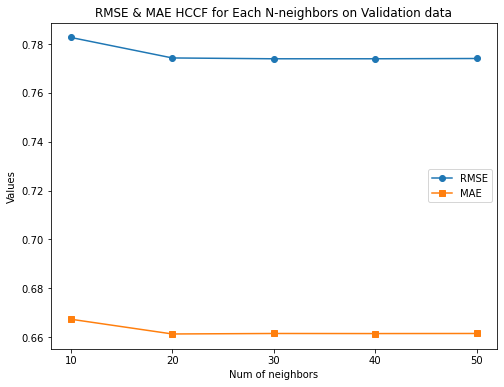

In [122]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors_hac, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors_hac, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE HCCF for Each N-neighbors on Validation data')
plt.legend()
plt.show()

### Evaluate HCCF all neighbors with test data

In [111]:
X_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_payment_installments  1094 non-null   float64
 1   total_payment_value         1094 non-null   float64
 2   geolocation_lat             1094 non-null   float64
 3   geolocation_lng             1094 non-null   float64
 4   total_payment_sequential    1094 non-null   float64
 5   payment_type_boleto         1094 non-null   uint8  
 6   payment_type_credit_card    1094 non-null   uint8  
 7   payment_type_debit_card     1094 non-null   uint8  
 8   payment_type_voucher        1094 non-null   uint8  
dtypes: float64(5), uint8(4)
memory usage: 47.1 KB


#### Scale data

In [112]:
X_test3.iloc[:, :] = scaler_hac.transform(X_test3.iloc[:, :])

In [113]:
X_test3.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,0.8,0.171649,0.395220,0.238928,0.0,0.0,1.0,0.0,0.0
1,0.8,0.884235,0.121593,0.239854,0.0,0.0,1.0,0.0,0.0
2,0.0,0.060413,0.374163,0.506760,0.0,0.0,1.0,0.0,0.0
3,0.0,0.653953,0.471862,0.540793,0.0,1.0,0.0,0.0,0.0
4,0.0,0.124168,0.618610,0.922323,0.0,1.0,0.0,0.0,0.0


#### Apply Hierarchical Clustering

In [114]:
# Hierarchical clustering
y_test3_predict = hac.fit_predict(X_test3)

# Silhouette score
silhouette_val = silhouette_score(X_test3, y_test3_predict)
print('Dataset test silhouette coef:', silhouette_val)

# tambah kolom kluster
y_test3['cluster'] = pd.Series(y_test3_predict)

Dataset test silhouette coef: 0.4503748684401373


In [115]:
y_test3['cluster'].value_counts()

0    696
2    254
3    109
1     35
Name: cluster, dtype: int64

#### Evaluate CF on test data

In [116]:
avg_rmse_all_neighbors_test3 = []
avg_mae_all_neighbors_test3 = []
exec_time_test3 = []
for n_neighbor in n_neighbors:
    print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
    rmse_all_test3 = []
    mae_all_test3 = []
    percentage_all_test3 = []
    avg_users_all_test3 = []


    tmp = y_test3.copy()
    n_clus = list(tmp['cluster'].unique())
    for n in n_clus:
        # get data cluster n
        dftmp = tmp[tmp['cluster'] == n]
        # dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

        # join with df rating
        df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

        # drop user who only rated below 2 product
        user_freq = dict(df_rating['customer_unique_id'].value_counts())
        user_list = [key for key, val in user_freq.items() if val < 2]
        idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
        df_rating.drop(idx, axis=0,inplace=True)

        # create rating matrix
        test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

        # get user
        cust_unique_id = test_rating_matrix.index
        for user in cust_unique_id:
            rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
            percentage_all_test3.append(item_predicted_percentage)
            avg_users_all_test3.append(avg_n_users)
            rmse_all_test3.append(rmse)
            mae_all_test3.append(mae)

    rmse3 = sum(filter(None, rmse_all_test3)) / len(rmse_all_test3)
    mae3 = sum(filter(None, mae_all_test3)) / len(mae_all_test3)
    
    avg_rmse_all_neighbors_test3.append(rmse3)
    avg_mae_all_neighbors_test3.append(mae3)
    print('############################################################')
    print('Dataset test:')
    print('Avg RMSE:',rmse3)
    print('Avg MAE:',mae3)
    print('Avg Percentage:',sum(filter(None, percentage_all_test3)) / len(percentage_all_test3))
    print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test3)) / len(avg_users_all_test3))

~~~~~~~~~~~~~ Num of neigbors :  10  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7733159170456049
Avg MAE: 0.6565611774910322
Avg Percentage: 87.51813041512612
Avg Num of Similar Users: 0.8734320820691509
~~~~~~~~~~~~~ Num of neigbors :  20  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7607669787249145
Avg MAE: 0.650505091074189
Avg Percentage: 87.51813041512612
Avg Num of Similar Users: 0.8734392283022989
~~~~~~~~~~~~~ Num of neigbors :  30  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7588107893395121
Avg MAE: 0.6491062093146795
Avg Percentage: 87.51813041512612
Avg Num of Similar Users: 0.8734420841427604
~~~~~~~~~~~~~ Num of neigbors :  40  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7583791507987039
Avg MAE: 0.6490732369495725
Avg Percentage: 

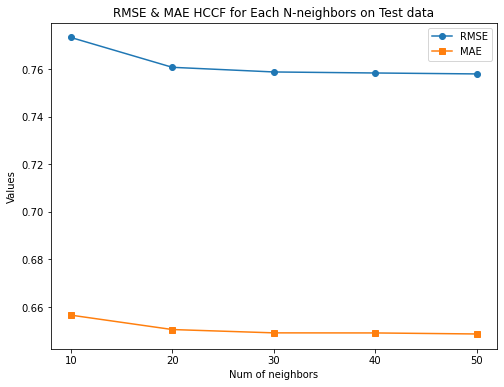

In [117]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors, avg_rmse_all_neighbors_test3, label='RMSE', marker='o')
plt.plot(n_neighbors, avg_mae_all_neighbors_test3, label='MAE', marker='s')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.title('RMSE & MAE HCCF for Each N-neighbors on Test data')
plt.legend()
plt.show()

## Result Comparison

## Comparison Result All Neighbors CF on Validation Data

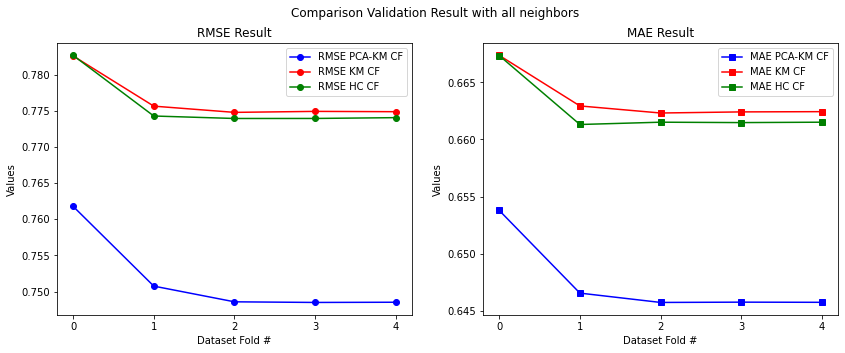

In [123]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
dfnum = [0, 1, 2, 3, 4]
plt.suptitle('Comparison Validation Result with all neighbors')

ax1 = plt.subplot('121', )
ax1.set_title('RMSE Result')
plt.xlabel('Dataset Fold #')
plt.xticks(dfnum)
plt.ylabel('Values')
plt.plot(dfnum, avg_rmse_all_neighbors, label='RMSE PCA-KM CF',color='blue', marker='o')
plt.plot(dfnum, avg_rmse_all_neighbors_km, label='RMSE KM CF',color='red', marker='o')
plt.plot(dfnum, avg_rmse_all_neighbors_hac, label='RMSE HC CF',color='green', marker='o')
plt.legend()

ax1 = plt.subplot('122')
ax1.set_title('MAE Result')
plt.xlabel('Dataset Fold #')
plt.xticks(dfnum)
plt.ylabel('Values')
plt.plot(dfnum, avg_mae_all_neighbors, label='MAE PCA-KM CF',color='blue', marker='s')
plt.plot(dfnum, avg_mae_all_neighbors_km, label='MAE KM CF',color='red',marker='s')
plt.plot(dfnum, avg_mae_all_neighbors_hac, label='MAE HC CF',color='green',marker='s')
plt.legend()

# f.tight_layout()
plt.show()

### Test all neighbors PCA-KM CF

In [ ]:
# # list num of neighbors
# n_neighbors = [10, 20, 30, 40, 50]
# avg_rmse_all_neighbors_test1 = []
# avg_mae_all_neighbors_test1 = []
# exec_time_test1 = []
# for n_neighbor in n_neighbors:
#     print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
#     rmse_all_test1 = []
#     mae_all_test1 = []
#     percentage_all_test1 = []
#     avg_users_all_test1 = []

#     start_time = time.time()
#     tmp = y_test.copy()
#     n_clus = list(tmp['cluster'].unique())
#     for n in n_clus:
#         # get data cluster n
#         dftmp = tmp[tmp['cluster'] == n]


#         # join with df rating
#         df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

#         # drop user who only rated below 2 product
#         user_freq = dict(df_rating['customer_unique_id'].value_counts())
#         user_list = [key for key, val in user_freq.items() if val < 2]
#         idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
#         df_rating.drop(idx, axis=0,inplace=True)

#         # create rating matrix
#         test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

#         # get user
#         cust_unique_id = test_rating_matrix.index
#         for user in cust_unique_id:
#             rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
#             percentage_all_test1.append(item_predicted_percentage)
#             avg_users_all_test1.append(avg_n_users)
#             rmse_all_test1.append(rmse)
#             mae_all_test1.append(mae)

#     # end of execution time
#     end_time = time.time()
#     exec_time_test1.append(end_time - start_time)
#     rmse1 = sum(filter(None, rmse_all_test1)) / len(rmse_all_test1)
#     mae1 = sum(filter(None, mae_all_test1)) / len(mae_all_test1)
    
#     avg_rmse_all_neighbors_test1.append(rmse1)
#     avg_mae_all_neighbors_test1.append(mae1)
#     print('############################################################')
#     print('Dataset test:')
#     print('Avg RMSE:',rmse1)
#     print('Avg MAE:',mae1)
#     print('Execution time: ',exec_time_test1)
#     print('Avg Percentage:',sum(filter(None, percentage_all_test1)) / len(percentage_all_test1))
#     print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test1)) / len(avg_users_all_test1))

### Test all neighbors KM CF

In [ ]:
# # list num of neighbors
# # n_neighbors = [5, 10, 15, 20]
# avg_rmse_all_neighbors_test2 = []
# avg_mae_all_neighbors_test2 = []
# exec_time_test2 = []
# for n_neighbor in n_neighbors:
#     print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
#     rmse_all_test2 = []
#     mae_all_test2 = []
#     percentage_all_test2 = []
#     avg_users_all_test2 = []

#     start_time = time.time()
#     tmp = y_test2.copy()
#     n_clus = list(tmp['cluster'].unique())
#     for n in n_clus:
#         # get data cluster n
#         dftmp = tmp[tmp['cluster'] == n]
#         # dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

#         # join with df rating
#         df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

#         # drop user who only rated below 2 product
#         user_freq = dict(df_rating['customer_unique_id'].value_counts())
#         user_list = [key for key, val in user_freq.items() if val < 2]
#         idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
#         df_rating.drop(idx, axis=0,inplace=True)

#         # create rating matrix
#         test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

#         # get user
#         cust_unique_id = test_rating_matrix.index
#         for user in cust_unique_id:
#             rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
#             percentage_all_test2.append(item_predicted_percentage)
#             avg_users_all_test2.append(avg_n_users)
#             rmse_all_test2.append(rmse)
#             mae_all_test2.append(mae)

#     # end of execution time
#     end_time = time.time()
#     exec_time_test2.append(end_time - start_time)
#     rmse2 = sum(filter(None, rmse_all_test2)) / len(rmse_all_test2)
#     mae2 = sum(filter(None, mae_all_test2)) / len(mae_all_test2)
    
#     avg_rmse_all_neighbors_test2.append(rmse2)
#     avg_mae_all_neighbors_test2.append(mae2)
#     print('############################################################')
#     print('Dataset test:')
#     print('Avg RMSE:',rmse2)
#     print('Avg MAE:',mae2)
#     print('Execution time: ',exec_time_test2)
#     print('Avg Percentage:',sum(filter(None, percentage_all_test2)) / len(percentage_all_test2))
#     print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test2)) / len(avg_users_all_test2))

### Test all neighbors HC CF

In [ ]:
# # list num of neighbors
# # n_neighbors = [5, 10, 15, 20]
# avg_rmse_all_neighbors_test3 = []
# avg_mae_all_neighbors_test3 = []
# exec_time_test3 = []
# for n_neighbor in n_neighbors:
#     print('~~~~~~~~~~~~~ Num of neigbors : ',n_neighbor,' ~~~~~~~~~~~~~~~~~')    
#     rmse_all_test3 = []
#     mae_all_test3 = []
#     percentage_all_test3 = []
#     avg_users_all_test3 = []

#     start_time = time.time()
#     tmp = y_test3.copy()
#     n_clus = list(tmp['cluster'].unique())
#     for n in n_clus:
#         # get data cluster n
#         dftmp = tmp[tmp['cluster'] == n]
#         # dftmp.drop(['dummy_rating', 'cluster'], axis=1, inplace=True)

#         # join with df rating
#         df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

#         # drop user who only rated below 2 product
#         user_freq = dict(df_rating['customer_unique_id'].value_counts())
#         user_list = [key for key, val in user_freq.items() if val < 2]
#         idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
#         df_rating.drop(idx, axis=0,inplace=True)

#         # create rating matrix
#         test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

#         # get user
#         cust_unique_id = test_rating_matrix.index
#         for user in cust_unique_id:
#             rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', n_neighbor)
#             percentage_all_test3.append(item_predicted_percentage)
#             avg_users_all_test3.append(avg_n_users)
#             rmse_all_test3.append(rmse)
#             mae_all_test3.append(mae)

#     # end of execution time
#     end_time = time.time()
#     exec_time_test3.append(end_time - start_time)
#     rmse3 = sum(filter(None, rmse_all_test3)) / len(rmse_all_test3)
#     mae3 = sum(filter(None, mae_all_test3)) / len(mae_all_test3)
    
#     avg_rmse_all_neighbors_test3.append(rmse3)
#     avg_mae_all_neighbors_test3.append(mae3)
#     print('############################################################')
#     print('Dataset test:')
#     print('Avg RMSE:',rmse3)
#     print('Avg MAE:',mae3)
#     print('Execution time: ',exec_time_test3)
#     print('Avg Percentage:',sum(filter(None, percentage_all_test3)) / len(percentage_all_test3))
#     print('Avg Num of Similar Users:',sum(filter(None, avg_users_all_test3)) / len(avg_users_all_test3))

## Comparison Result All Neighbors CF on Test Data

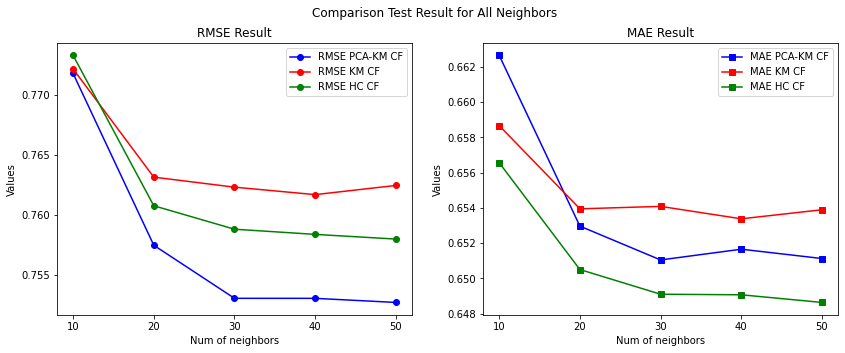

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
plt.suptitle('Comparison Test Result for All Neighbors')

ax1 = plt.subplot('121', )
ax1.set_title('RMSE Result')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.plot(n_neighbors, avg_rmse_all_neighbors_test1, label='RMSE PCA-KM CF',color='blue', marker='o')
plt.plot(n_neighbors, avg_rmse_all_neighbors_test2, label='RMSE KM CF',color='red', marker='o')
plt.plot(n_neighbors, avg_rmse_all_neighbors_test3, label='RMSE HC CF',color='green', marker='o')
plt.legend()

ax1 = plt.subplot('122')
ax1.set_title('MAE Result')
plt.xlabel('Num of neighbors')
plt.xticks(n_neighbors)
plt.ylabel('Values')
plt.plot(n_neighbors, avg_mae_all_neighbors_test1, label='MAE PCA-KM CF',color='blue', marker='s')
plt.plot(n_neighbors, avg_mae_all_neighbors_test2, label='MAE KM CF',color='red',marker='s')
plt.plot(n_neighbors, avg_mae_all_neighbors_test3, label='MAE HC CF',color='green',marker='s')
plt.legend()

# f.tight_layout()
plt.show()